In [2]:
%%capture --no-stderr
!pip install yfinance
!pip install lxml_html_clean 
!pip install requests_html

In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from dateutil.relativedelta import relativedelta
import requests
from requests_html import HTMLSession
import matplotlib.pyplot as plt

# Momentum trading strategy
Momentum trading involves buying and/or selling assets according to recent price trends, assuming that these trends will continue in the same direction.
When an asset displays an upward trend, it invariably attracts more attention from investors and this fuels its price further. This momentum endures until a significant number of sellers enter the market, leading to a change in momentum's direction and forces the price to go lower.
This approach essentially exploits market herding behavior, a phenomenon in which traders tend to follow the majority of the market consensus. In periods of strong upward or downward trends, many  investors may decide to follow the crowd to long or short popular assets, thereby augmenting the existing momentum. 

For this strategy to be interesting, we need to time the beginning and the end of the momentum. We can use different technical indicators:
* Volume: A high trading volume often indicates a strong interest in the asset and can be an indicator of the start of a new trend, while a low volume could signal a lack of interest in the asset,  and a potential reversal in trend
* Volatility: A higher volatility can provide good trading opportunities if the variation is in the profitable direction. However, volatility also increases the risk for significant losses. Therefore, understanding and managing volatility is a critical aspect of
* Time frame: The time frame represents the expected duration of the identified trend. 

Even if both trend-following and momentum trading strategies are built on momentum, they are different. Indeed, the momentum trading strategy is cross-sectional, ie it involves comparing the
momentum across various assets at a specific time point and investing in those that demonstrate the highest momentum. In contrast, the trend-following strategy utilizes time series momentum, focusing exclusively on an asset’s own historical performance over time. 

The momentum trading strategy uses a singular lookback window to identify which assets have performed best over the defined lookback period.
Then, another lookahead window is used to determine the holding period of a position once a trading decision is made. 


In [9]:
def get_sharpe_ratio(monthly_returns, lookback_window_size=6, lookahead_window_size=1, nb_quantiles=5, riskfree_rate=.04, plot=True):
    past_returns = (monthly_returns+1).rolling(lookback_window_size).apply(np.prod)-1 #compound returns over the last lookback_window_size months
    past_returns.dropna(axis=0, inplace=True) #drop the first lookback_window_size-1 lines
    evaluation_returns = (monthly_returns+1).rolling(lookahead_window_size).apply(np.prod)-1
    evaluation_returns.dropna(axis=0, inplace=True) 
    momentum_returns = pd.DataFrame(columns=['Return'], index=past_returns.index)
    #for each date we create a portfolio where we long the best performers of the last lookback_window_size months and short the worst performers
    for i in range(0, past_returns.index.shape[0]-lookahead_window_size, lookahead_window_size): # we do not take the last lookahead_window_size dates because we will not be able to evaluate our portfolio for these dates, we do not modify our portfolio during the evaluation period so the future trade date is lookahead_window_size months after (which explains the step)
        observation_date = past_returns.index[i]
        observation_returns = past_returns.loc[observation_date].reset_index() #returns of the last lookback_window_size months at the observation date
        observation_returns['Quantile'] = pd.qcut(observation_returns.iloc[:, 1], nb_quantiles, labels=False) # we create quantile to identify the best performers and the worst performers
        long_stocks = observation_returns.loc[observation_returns["Quantile"]==nb_quantiles-1, "Ticker"].values # we long the best performers
        short_stocks = observation_returns.loc[observation_returns["Quantile"]==0, "Ticker"].values # we short the worst performers
        evaluation_date = observation_date.replace(day=1)+relativedelta(months=lookahead_window_size+1, days=-1) #last day of next month
        long_returns = evaluation_returns.loc[evaluation_date, long_stocks] # returns of long stocks over the lookahead_window_size future months
        short_returns = evaluation_returns.loc[evaluation_date, short_stocks]
        momentum_returns.loc[evaluation_date] = long_returns.mean() - short_returns.mean() #we assume an equally-weighted portfolio
    momentum_returns.dropna(axis=0, inplace=True)
    nb_years= relativedelta(momentum_returns.index[-1],momentum_returns.index[0]).years + relativedelta(momentum_returns.index[-1],momentum_returns.index[0]).months/12 + relativedelta(momentum_returns.index[-1],momentum_returns.index[0]).days/365 #Number of years in the trading period
    annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
    annualized_vol = (momentum_returns['Return'].std()/nb_years)**.5
    sharpe_ratio = (annualized_return- riskfree_rate)/annualized_vol
    if plot:
        momentum_returns_plot = pd.concat([pd.DataFrame({'Return':0}, index=[momentum_returns.index[0]-relativedelta(months=1)]), momentum_returns])
        (1+momentum_returns_plot['Return']).cumprod().plot()
    return sharpe_ratio

### Dow Jones

We use the Dow Jones index as the reference universe. We scrap the constituents from the wikipedia page.

In [16]:
def get_dji_tickers():
    try:
        url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:101.0) Gecko/20100101 Firefox/101.0',
        'Accept': 'application/json',
        'Accept-Language': 'en-US,en;q=0.5',
        }
        # Send GET request
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        # Get the symbols table
        tables = soup.find_all('table')
        # # Convert table to dataframe
        df = pd.read_html(str(tables))[1]
        return df['Symbol'].values.tolist()
    except:
        print('Error loading data')
        return None

In [17]:
start_date = "2016-01-01"
end_date = "2024-06-01"
tickers = get_dji_tickers()
df = yf.download(tickers, start=start_date, end=end_date)
df = df['Adj Close']

daily_returns = df.pct_change(fill_method=None)
monthly_returns = daily_returns.resample('ME').agg(lambda x: (x+1).prod()-1)

/tmp/ipykernel_33/645998881.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables))[1]
[*********************100%%**********************]  30 of 30 completed


In [18]:
for lookback_window_size in [1,2,3,4,6,8,10,12]:
    for lookahead_window_size in [1,2,3,4,6,8,10,12]:
        sharpe_ratio=get_sharpe_ratio(monthly_returns, lookback_window_size=lookback_window_size, lookahead_window_size=lookahead_window_size, plot=False)
        if(sharpe_ratio>0):
            print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(lookback_window_size, lookahead_window_size, sharpe_ratio))

Lookback: 1 	 Lookahead: 6 	 Sharpe ratio: 0.2914673319098983


0.2914673319098983

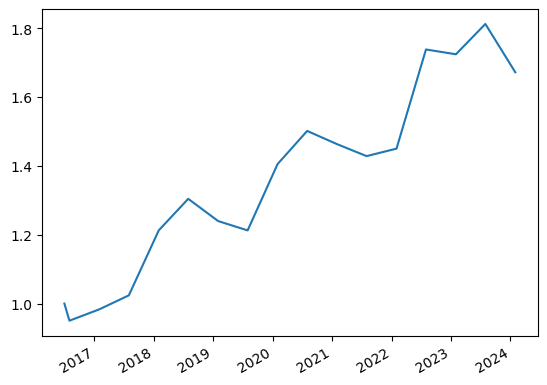

In [19]:
 get_sharpe_ratio(monthly_returns, lookback_window_size=1, lookahead_window_size=6)

### S&P 500

In [20]:
def get_spx_tickers():
    try:
        url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:101.0) Gecko/20100101 Firefox/101.0',
        'Accept': 'application/json',
        'Accept-Language': 'en-US,en;q=0.5',
        }
        # Send GET request
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        # Get the symbols table
        tables = soup.find_all('table')
        # # Convert table to dataframe
        df = pd.read_html(str(tables))[0]
        return df['Symbol'].values.tolist()
    except:
        print('Error loading data')
        return None

In [56]:
start_date = "2016-01-01"
end_date = "2024-06-01"
tickers = get_spx_tickers()
df = yf.download(tickers, start=start_date, end=end_date)
df = df['Adj Close']

daily_returns = df.pct_change(fill_method=None)
monthly_returns = daily_returns.resample('ME').agg(lambda x: (x+1).prod()-1)
stocks_to_delete = monthly_returns.columns[(monthly_returns==0).sum()>0] #drop the stocks that have a return zero during at least one month
print("{} stocks deleted".format(len(stocks_to_delete)))
monthly_returns = monthly_returns.drop(stocks_to_delete, axis=1) 

/tmp/ipykernel_33/2188847483.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables))[0]
[******                12%%                      ]  60 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2016-01-01 -> 2024-06-01)


[*********************100%%**********************]  503 of 503 completed


31 stocks deleted


In [47]:
for lookback_window_size in [1,2,3,4,6,8,10,12]:
    for lookahead_window_size in [1,2,3,4,6,8,10,12]:
        sharpe_ratio=get_sharpe_ratio(monthly_returns, lookback_window_size=lookback_window_size, lookahead_window_size=lookahead_window_size, nb_quantiles=50, plot=False)
        if(sharpe_ratio>0):
            print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(lookback_window_size, lookahead_window_size, sharpe_ratio))

/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


Lookback: 2 	 Lookahead: 3 	 Sharpe ratio: 0.29954082325448295
Lookback: 2 	 Lookahead: 6 	 Sharpe ratio: 0.07304673441465419
Lookback: 2 	 Lookahead: 12 	 Sharpe ratio: 0.9742671258141081


/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


Lookback: 6 	 Lookahead: 4 	 Sharpe ratio: 0.27239997370120567
Lookback: 6 	 Lookahead: 6 	 Sharpe ratio: 0.7022564615207121
Lookback: 6 	 Lookahead: 8 	 Sharpe ratio: 0.37813943896057944
Lookback: 6 	 Lookahead: 10 	 Sharpe ratio: 0.3379813212849484
Lookback: 8 	 Lookahead: 3 	 Sharpe ratio: 0.8592346655785755
Lookback: 8 	 Lookahead: 4 	 Sharpe ratio: 1.1294966720180724
Lookback: 8 	 Lookahead: 6 	 Sharpe ratio: 0.5384523396902585
Lookback: 8 	 Lookahead: 8 	 Sharpe ratio: 0.12511163178134546
Lookback: 8 	 Lookahead: 10 	 Sharpe ratio: 0.28549714523406616
Lookback: 10 	 Lookahead: 3 	 Sharpe ratio: 0.7281125502588636


/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


Lookback: 10 	 Lookahead: 10 	 Sharpe ratio: 0.8842275390185113
Lookback: 12 	 Lookahead: 4 	 Sharpe ratio: 0.3543577218159855
Lookback: 12 	 Lookahead: 6 	 Sharpe ratio: 0.2271400474940481
Lookback: 12 	 Lookahead: 8 	 Sharpe ratio: 0.5486430345855186
Lookback: 12 	 Lookahead: 10 	 Sharpe ratio: 0.3188772942137169
Lookback: 12 	 Lookahead: 12 	 Sharpe ratio: 0.5637829962878642


1.1294966720180724

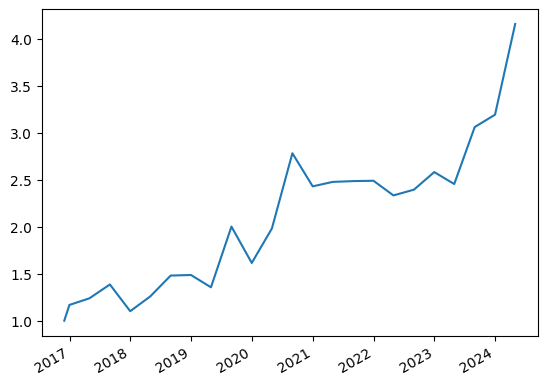

In [52]:
get_sharpe_ratio(monthly_returns, lookback_window_size=8, lookahead_window_size=4, nb_quantiles=50)

### Cryptocurrencies

In [61]:
session = HTMLSession()
num_currencies=100
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
crypto_tickers = df.Symbol.tolist()

In [62]:
start_date = "2021-01-01" # we reduce the time frame because no data was available for most of cryptocurrencies in 2016
end_date = "2024-06-01"
df = yf.download(crypto_tickers, start=start_date, end=end_date)
df = df['Adj Close']

[*********************100%%**********************]  100 of 100 completed


In [63]:
daily_returns = df.pct_change(fill_method=None)
monthly_returns = daily_returns.resample('ME').agg(lambda x: (x+1).prod()-1)
stocks_to_delete = monthly_returns.columns[(monthly_returns==0).sum()>0] #drop the stocks that have a return zero during at least one month
print("{} stocks deleted".format(len(stocks_to_delete)))
monthly_returns = monthly_returns.drop(stocks_to_delete, axis=1) 

/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


48 stocks deleted


In [66]:
for lookback_window_size in [1,2,3,4,6,8,10,12]:
    for lookahead_window_size in [1,2,3,4,6,8,10,12]:
        sharpe_ratio=get_sharpe_ratio(monthly_returns, lookback_window_size=lookback_window_size, lookahead_window_size=lookahead_window_size, nb_quantiles=10, plot=False)
        if(sharpe_ratio>3):
            print("Lookback: {} \t Lookahead: {} \t Sharpe ratio: {}".format(lookback_window_size, lookahead_window_size, sharpe_ratio))

/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


Lookback: 1 	 Lookahead: 12 	 Sharpe ratio: 3.750443508541408


/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


Lookback: 2 	 Lookahead: 12 	 Sharpe ratio: 3.836703359554511


/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


Lookback: 3 	 Lookahead: 12 	 Sharpe ratio: 3.325029922741889


/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1
/tmp/ipykernel_33/327221448.py:20: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1+momentum_returns['Return']).prod()**(1/nb_years)-1


3.836703359554511

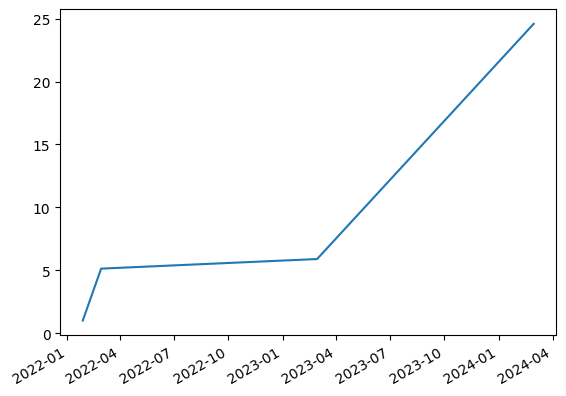

In [68]:
get_sharpe_ratio(monthly_returns, lookback_window_size=2, lookahead_window_size=12, nb_quantiles=10)

This particularly good result may due to the bull market in the beginning of 2024.

# MACD (Moving Average Convergence Divergence)

MACD is designed to reveal changes in the strength, direction, momentum, and duration of a trend in a stock's price.

The MACD indicator is built by using three time series: the MACD series proper, the "signal" or "average" series, and the "divergence" series which is the difference between the two. The MACD series is the difference between a "fast" (short period) exponential moving average (EMA), and a "slow" (longer period) EMA of the price series. The average series is an EMA of the MACD series itself.

The MACD indicator thus depends on three time parameters, namely the time constants of the three EMAs. The notation "MACD(a,b,c)" usually denotes the indicator where the MACD series is the difference of EMAs with characteristic times a and b, and the average series is an EMA of the MACD series with characteristic time c. These parameters are usually measured in days. The most commonly used values are 12, 26, and 9 days, that is, MACD(12,26,9). 

Source: [Wikipedia page of MACD](https://en.wikipedia.org/wiki/MACD])

In [32]:
df = yf.download(['AAPL'], start="2021-01-01", end="2024-05-31")

[*********************100%%**********************]  1 of 1 completed


The 12-period EMA is more responsive to recent price changes, providing sensitivity to short-term price movements. In contrast, the 26-period EMA is smoother and reacts more slowly, capturing longer-term trends. This combination helps the MACD identify potential shifts in momentum across various timeframes.

The MACD’s name itself reflects its capacity to detect both convergence (when the MACD line crosses above the Signal Line) and divergence (when it crosses below the Signal Line). This duality makes it a versatile tool for traders interested in both trend-following and reversal strategies.

In [33]:
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

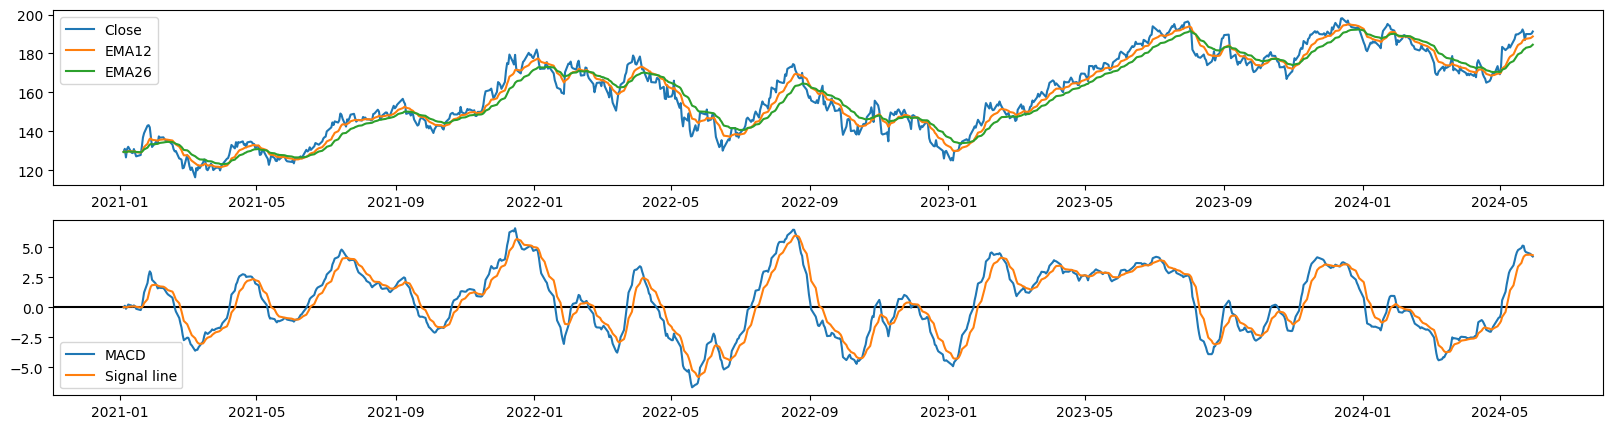

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(df.index, df['Close'], label="Stock price")
plt.plot(df.index, df['EMA12'], label="EMA12")

plt.plot(df.index, df['EMA26'], label="EMA26")
plt.legend()
plt.subplot(2,1,2)
plt.axhline(color='black')
plt.plot(df.index, df['MACD'], label="MACD")
plt.plot(df.index, df['Signal_Line'], label="Signal line")
plt.legend()

Each time the MACD line crosses the x axis means the two EMA time series cross each other. When the MACD line is above the x axis, the fast EMA is above the slow EMA, meaning the price is bullish. Conversely, when the MACD line is below the x axis, the price is bearish. 

When the MACD line is above its EMA (the signal line), the price is particularly bullish and we can consider this a trading signal for buying the stock. 

# RSI (Relative Strength Index)

In [ ]:
https://en.wikipedia.org/wiki/Relative_strength_index

# Trend following

See quantitative trading strategies using Python